In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

In [2]:
orders = pd.read_csv("../Downloads/bl_data/bl_fulfillment_orders.csv", parse_dates = ["created_at"])
order_states = pd.read_csv("../Downloads/bl_data/bl_fulfillment_order_states.csv", parse_dates = ["created_at"])
order_items = pd.read_csv("../Downloads/bl_data/bl_fulfillment_order_items.csv", parse_dates = ["created_at"])

In [3]:
order_states["created_month"] = order_states["created_at"].dt.month
order_states["created_year"] = order_states["created_at"].dt.year

In [4]:
################

In [5]:
bb_orderid = np.array(orders[orders["order_type"] == "hello_baby_box"]["id"])
order_states_bb = order_states[order_states["order_id"].isin(bb_orderid)]
order_states_nobb = order_states[~order_states["order_id"].isin(bb_orderid)]

shipped_nobb = order_states_nobb[order_states_nobb["state"] == "shipped"]
by_month_nobb = shipped_nobb[["created_year","created_month","order_id"]].groupby(["created_year","created_month"]).count()
by_month_nobb.rename({"order_id": "num_shipments"}, axis="columns", inplace=True)
days_in_month = np.array([31,28,31,30,31,30,31,31,30,31,30,31,31,28,25])
by_month_nobb["per_day"] = by_month_nobb["num_shipments"] / days_in_month

shipped_bb = order_states_bb[order_states_bb["state"] == "shipped"]
by_month_bb = shipped_bb[["created_year","created_month","order_id"]].groupby(["created_year","created_month"]).count()
by_month_bb.rename({"order_id": "num_shipments"}, axis="columns", inplace=True)
days_in_month = np.array([28,31,30,31,30,31,31,30,31,30,31,31,28,25])
by_month_bb["per_day"] = by_month_bb["num_shipments"] / days_in_month
by_month_bb.loc[(2018, 1), :] = [0, 0]
by_month_bb.sort_index(inplace=True)

## Orders Shipped per Month

Below, I've graphed average daily shipments per month split into Baby Boxes and everything else.  The overall pattern is similar to that of daily orders.

(array([ 0.2,  1.2,  2.2,  3.2,  4.2,  5.2,  6.2,  7.2,  8.2,  9.2, 10.2,
        11.2, 12.2, 13.2, 14.2]), <a list of 15 Text xticklabel objects>)

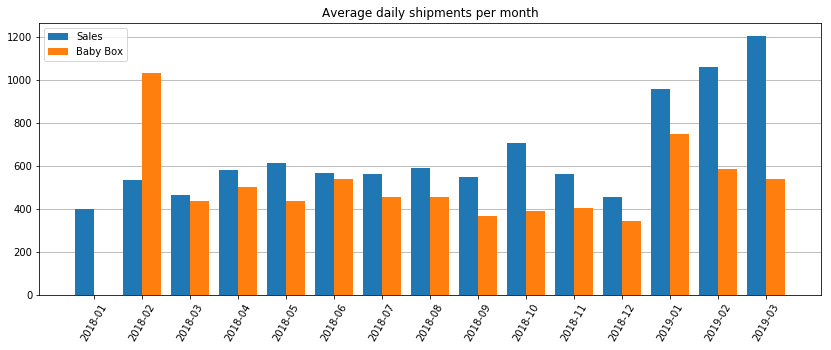

In [6]:
labels = []
for i in by_month_nobb.index:
    y = i[0]
    m = i[1]
    if m < 10:
        labels.append(str(i[0]) + "-0" + str(i[1]))
    else:
        labels.append(str(i[0]) + "-" + str(i[1]))


ind = np.arange(len(labels))
width = .4
fig, ax = plt.subplots(figsize=(14, 5))
ax.yaxis.grid(which="major", zorder=0)
p1 = ax.bar(ind, by_month_nobb["per_day"], width, zorder=3)
p2 = ax.bar(ind+width, by_month_bb["per_day"], width, zorder=3)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels)
ax.set_title("Average daily shipments per month")
ax.legend((p1[0], p2[0]), ('Sales', 'Baby Box'))
plt.xticks(rotation=60)


## No Baby Boxes Shipped in Jan-2018

One thing that jumps out on the graph above is the number of Baby Boxes shipped in Jan-18 and Feb-18.  It appears that the Boxes ordered in both January and February were all shipped in February.  I looked at five random Baby Box orders from January below, and it seems that regardless of when an order was opened it was ordered on January 31st at the earliest and then wasn't shipped for another few days.

In [7]:
bb_orders = orders[orders["order_type"] == "hello_baby_box"]
jan_bb_orders = bb_orders[bb_orders["created_at"] < pd.Timestamp(2018,2,1)]
random_ids = np.random.choice(jan_bb_orders["id"], 5, replace=False)
order_states[order_states["order_id"].isin(random_ids)].sort_values(["order_id","created_at"])

,id,order_id,state,created_at,created_month,created_year
40624,513158,177158,open_order,2018-01-03 20:10:52,1,2018
78518,581163,177158,ordered,2018-01-31 06:17:46,1,2018
118021,612445,177158,shipped,2018-02-08 18:57:42,2,2018
47363,520686,182930,open_order,2018-01-07 02:11:38,1,2018
88810,584690,182930,ordered,2018-01-31 17:50:34,1,2018
93367,615134,182930,shipped,2018-02-08 19:56:21,2,2018
75701,549585,206700,open_order,2018-01-18 19:14:08,1,2018
119627,618869,206700,ordered,2018-02-09 00:31:53,2,2018
150101,640784,206700,shipped,2018-02-12 17:27:38,2,2018
56951,556560,215854,open_order,2018-01-22 01:45:08,1,2018


In [8]:
####################

In [9]:
def interval_check(sec, lower, upper):
    if sec < lower*3600 or sec > upper*3600:
        return False
    else:
        return True

def create_time_diff(start_date, end_date):
    time_diff = orders[orders["created_at"] >= start_date]
    time_diff = time_diff[time_diff["created_at"] <= end_date]
    join_piece = order_states.set_index("order_id")[["state", "created_at"]]
    time_diff = time_diff.join(join_piece, on="id", how="inner", lsuffix="_begin", rsuffix="_end")
    time_diff = time_diff[time_diff["state_end"] == "shipped"]
    time_diff = time_diff[["id", "created_at_begin", "created_at_end", "order_type"]]
    time_diff = time_diff.rename({"created_at_begin":"time_placed","created_at_end":"time_complete"},axis = "columns")
    time_diff["time_to_ship"] = time_diff["time_complete"] - time_diff["time_placed"]
    time_diff["time_in_sec"] = time_diff["time_to_ship"].apply(lambda x: x.total_seconds())
    time_diff["within_12"] = time_diff["time_in_sec"] <= 3600*12
    time_diff["12-24"] = time_diff["time_in_sec"].apply(interval_check, args = (12, 24))
    time_diff["24-48"] = time_diff["time_in_sec"].apply(interval_check, args = (24, 48))
    time_diff["gt_48"] = time_diff["time_in_sec"] > 3600*48
    return(time_diff)

def calc_buckets(time_diff):
    s1 = np.sum(time_diff["within_12"])
    s2 = np.sum(time_diff["12-24"])
    s3 = np.sum(time_diff["24-48"])
    s4 = np.sum(time_diff["gt_48"])
    s_all = len(time_diff)
    p1 = np.round(s1/s_all,3)
    p2 = np.round(s2/s_all,3)
    p3 = np.round(s3/s_all,3)
    p4 = np.round(s4/s_all,3)
    return (s1, p1, s2, p2, s3, p3, s4, p4, s_all)

## Time from Order to Shipment, Last 30 Days

To measure the time from when an order was placed to when it shipped, I looked at the time an order was created in the orders table and compared that to the time the order was shipped according to the order_states table.  I then bucketed all time differences into <12 hours, 12-24 hours, 24-48 hours, or 48+ hours.  All orders were counted (Baby Box and other).  The results are below.

In [10]:
last_date = np.max(orders["created_at"]).round(freq="1D")
ago_30 = last_date - pd.Timedelta(days=30)
time_diff_30 = create_time_diff(ago_30, last_date)
(s1, p1, s2, p2, s3, p3, s4, p4, s_all) = calc_buckets(time_diff_30)
print(" " + str(s1) + " out of " + str(s_all) + " (" + str(100*p1) + "%) orders shipped within 12 hours.")
print(str(s2) + " out of " + str(s_all) + " (" + str(100*p2) + "%) orders shipped within 12 to 24 hours. ")
print(str(s3) + " out of " + str(s_all) + " (" + str(100*p3) + "%) orders shipped within 24 to 48 hours. ")
print(str(s4) + " out of " + str(s_all) + " (" + str(100*p4) + "%) orders shipped after more than 48 hours. ")

 9050 out of 50674 (17.9%) orders shipped within 12 hours.
13567 out of 50674 (26.8%) orders shipped within 12 to 24 hours. 
17454 out of 50674 (34.4%) orders shipped within 24 to 48 hours. 
10603 out of 50674 (20.9%) orders shipped after more than 48 hours. 


In [11]:
df = pd.DataFrame(index = ["s1","p1","s2","p2","s3","p3","s4","p4","s_all"])
aoc = [10,11,12,1,2,3,4]
for k in range(len(aoc)-1):
    m1 = aoc[k]
    m2 = aoc[k+1]
    y1 = 2018 if m1 >= 10 else 2019
    y2 = 2018 if m2 >= 10 else 2019
    td = create_time_diff(pd.Timestamp(y1,m1,1), pd.Timestamp(y2,m2,1))
    buckets = calc_buckets(td)
    lab = str(y1) + "-" + str(m1)
    df[lab] = buckets

## Monthly Time From Ordering to Shipment, Last 6 Months

Using the same methodology as above, I examine times from ordering to shipment over the last 6 months.  The stacked area chart below lets us see the change in shipping patterns over this timeframe.  We notice that orders got slower from October to November, with the 48+ share growing from under 40% to over 50%.  The share of 48+ dropped sharply in February and then again to a lesser extent in March.  This was mostly due to increases in the 12-24 and 24-48 buckets, though we also see steady increase in the <12 bucket.  Almost no orders made it to shipping in less than 12 hours back in Octobber, and that rate has steadily risen to 18% in March.

Text(0.5, 1.0, 'Percent of orders taking <12, 12-24, 24-48, and >48 hours; past 6 months')

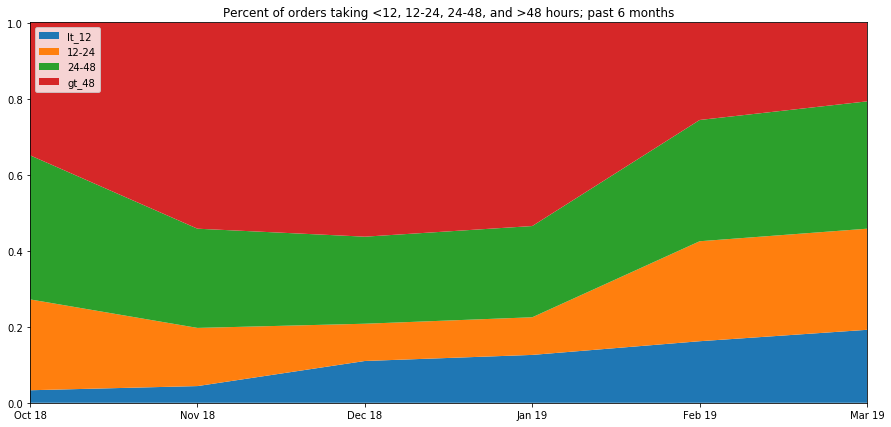

In [12]:
fig, ax = plt.subplots(figsize=(15, 7))
x_labs = ["Oct 18", "Nov 18", "Dec 18", "Jan 19", "Feb 19", "Mar 19"]
ax.stackplot(x_labs, df.loc["p1",:], df.loc["p2",:], df.loc["p3",:], df.loc["p4",:],
             labels=["lt_12","12-24","24-48","gt_48"])
ax.legend(loc='upper left')
ax.margins(0,0)
ax.set_title("Percent of orders taking <12, 12-24, 24-48, and >48 hours; past 6 months")

In [13]:
############

## Time to Shipment by Item

Here, we examine the time from ordering to shipment at the item level.  I've shown the 25 most commonly ordered items over the last 30 days as well as their average and median times to shipment.  The first thing to notice is that gift cards have a very different shipping pattern than other items.  Most ship almost instantly, with a small few taking several hours.  Other items typically take around 30 hours from ordering to shipment.  Most of these have a median ship time lower than the mean.  This implies that the shipping time for most items is skewed such that a few very long time intervals brings up the average.

In [14]:
item_ship = time_diff_30.join(order_items.set_index("order_id")[["name"]], how="inner", on="id")
item_ship["time_in_hours"] = item_ship["time_in_sec"]/3600

item_ship_count = item_ship[["name", "time_in_hours"]].groupby("name").count()
item_ship_count.rename({"time_in_hours": "num_orders"}, axis = "columns", inplace = True)
item_ship_mean = item_ship[["name", "time_in_hours"]].groupby("name").mean()
item_ship_mean.rename({"time_in_hours": "ave_ship_time"}, axis = "columns", inplace = True)
item_ship_std = item_ship[["name", "time_in_hours"]].groupby("name").std()
item_ship_std.rename({"time_in_hours": "std_ship_time"}, axis = "columns", inplace = True)
item_ship_med = item_ship[["name", "time_in_hours"]].groupby("name").median()
item_ship_med.rename({"time_in_hours": "med_ship_time"}, axis = "columns", inplace = True)

items = pd.concat([item_ship_count, item_ship_mean, item_ship_std, item_ship_med], axis=1)
items.sort_values("num_orders", ascending=False, inplace=True)
items["ave-med"] = items["ave_ship_time"] - items["med_ship_time"]
items_head25 = items.head(n=25)
items_head25

,num_orders,ave_ship_time,std_ship_time,med_ship_time,ave-med
name,,,,,
Babylist Hello Baby Box - March 2019,7988,41.419506,31.401248,24.165972,17.253534
Babylist Hello Baby Box - February 2019,7957,23.445743,15.970616,24.037500,-0.591757
Babylist Store Gift Card - 50,1975,0.979864,6.175747,0.000833,0.979030
Babylist Store Gift Card - 100,1471,0.799152,5.546898,0.000833,0.798319
"Hatch Baby Rest Sound Machine, Night Light & Time-to-Rise",1277,29.607326,19.853149,25.263333,4.343993
Babylist Bottle Box,1117,33.352936,18.868514,30.492778,2.860158
Babylist Store Gift Card - 25,1114,1.209097,7.361682,0.000833,1.208264
Lovevery The Play Gym,600,28.579863,19.155973,23.977778,4.602085
FridaBaby NoseFrida The Snotsucker Nasal Aspirator,451,34.201013,18.451039,35.254444,-1.053431


## Shipping Gift Cards

Here we see that over 94% of gift cards ship within 10 seconds.  Average shipping time is still around an hour, as the 6% that take longer than ten seconds can often take up to a day to ship.

In [15]:
item_ship_gc = item_ship[item_ship["name"].str.match("Babylist Store Gift Card.*")]
gc_total = len(item_ship_gc)
gc_lte_10 = sum(item_ship_gc["time_in_sec"] <= 10)
print("Number of gift card orders that \"ship\" within 10 seconds:")
print(str(gc_lte_10) + " out of " + str(gc_total) + " (" + str(np.round(100*gc_lte_10/gc_total, 1)) + "%)")

Number of gift card orders that "ship" within 10 seconds:
4828 out of 5118 (94.3%)


## Means > Medians

The three most commonly ordered items that have the highest median shipping times also are some of the only items with averages larger than their medians.  I would want to try and investigate to see if there is anything that these items might have in common.

In [16]:
items_head25.sort_values("med_ship_time", ascending=False).head(n=10)

,num_orders,ave_ship_time,std_ship_time,med_ship_time,ave-med
name,,,,,
Earth Mama Organic Diaper Balm - 2 oz,246,38.608608,20.317485,40.906806,-2.298198
Britax Back Seat Mirror - Silver,339,37.667864,19.029749,38.597778,-0.929914
FridaBaby NoseFrida The Snotsucker Nasal Aspirator,451,34.201013,18.451039,35.254444,-1.053431
Dr. Brown's Natural Flow Original Newborn Bottle Gift Set,321,33.952541,19.816357,32.887222,1.065318
Philips Avent Soothie Pacifier (2 Pack) - Green,289,35.339431,19.824442,32.232778,3.106653
Boppy Bare Naked Nursing Pillow and Positioner,325,33.842561,18.075441,32.006944,1.835616
Babylist Bottle Box,1117,33.352936,18.868514,30.492778,2.860158
Boppy Newborn Lounger - Elephant Love,318,32.251924,18.999577,29.764722,2.487202
Boon Lawn Countertop Drying Rack - Green,364,33.490961,19.848125,29.648056,3.842905


## Distribution of Shipping Times, All Items Last 30 Days

Below is a histogram displaying the distribution of shipping times per item.  We see a rough approximation of a skewed normal curve, with most of the mass in the 0-48 hours range and then a long tail that goes out past 100 hours.  The 40-50 hour bucket looks larger than expected.  I'm curious if that is because there is incentive to get orders shipped within 48 hours, but not necessarily any faster than that.

Text(0.5, 1.0, 'Distribution - Hours to ship, all items last 30 days')

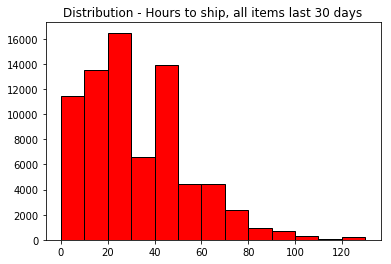

In [17]:
it_dist = np.array(item_ship["time_in_hours"])
plt.hist(it_dist, edgecolor='black', bins = np.arange(0,140,10), color="red")
plt.title("Distribution - Hours to ship, all items last 30 days")

In [18]:
td_six_mo = create_time_diff(pd.Timestamp(2018,10,1), pd.Timestamp(2019,4,1))
item_six_mo = td_six_mo.join(order_items.set_index("order_id")[["name"]], how="inner", on="id")

In [19]:
item_six_mo["month"] = (item_six_mo["time_placed"].dt.month).astype(str)
item_six_mo["year"] = (item_six_mo["time_placed"].dt.year).astype(str)
item_six_mo["y-m"] = item_six_mo["year"] + item_six_mo["month"]

In [20]:
item_six_mo = item_six_mo[~item_six_mo["name"].str.match("Babylist Store Gift Card.*")]

In [21]:
counts_nogc = item_six_mo[["y-m","within_12","12-24","24-48","gt_48"]].groupby("y-m").sum()
row_sums = np.array(counts_nogc.apply(sum,axis=1)).reshape(6,1)
prop_nogc = pd.DataFrame(index = counts_nogc.index,
                         data = counts_nogc.values / row_sums,
                         columns = counts_nogc.columns)

## Revisiting the 6 Month Retrospective

Knowing what I now know about gift cards, I wanted to redo the area chart with gift cards removed.  The main difference is the <12 bucket has shrunk, although we can still see it increasing from October to March.

Text(0.5, 1.0, 'Percent of orders taking <12, 12-24, 24-48, and >48 hours, no gift cards; past 6 months')

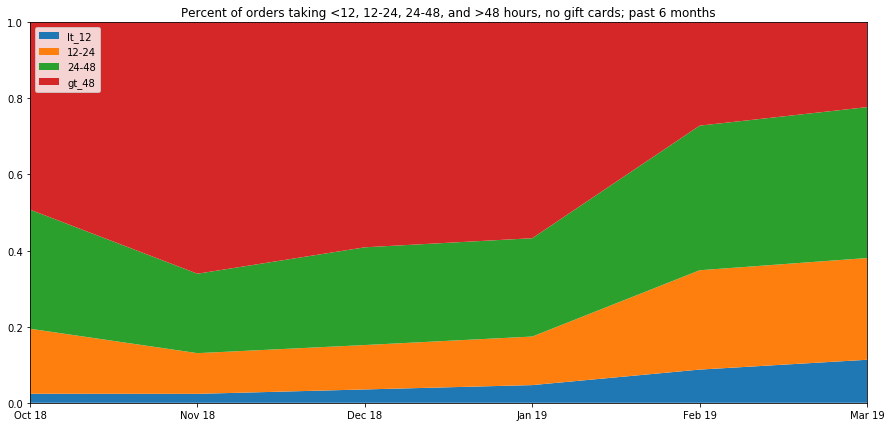

In [22]:
fig, ax = plt.subplots(figsize=(15, 7))
x_labs = ["Oct 18", "Nov 18", "Dec 18", "Jan 19", "Feb 19", "Mar 19"]
ax.stackplot(x_labs, prop_nogc.loc[:,"within_12"], prop_nogc.loc[:,"12-24"],
             prop_nogc.loc[:,"24-48"], prop_nogc.loc[:,"gt_48"],
             labels=["lt_12","12-24","24-48","gt_48"])
ax.legend(loc='upper left')
ax.margins(0,0)
ax.set_title("Percent of orders taking <12, 12-24, 24-48, and >48 hours, no gift cards; past 6 months")